Welcome to the Lab session of the ReLearn Course. This notebook contains three sections with problems spacing the content of the course.

Just a few indications:
- There are questions where you will be required to explain your design choices or some results. Be as informative as possible, but try to keep it concise!
- Comments on the results are well accepted and encouraged.
- In the last section, some code is already provided. Feel free to modify it if you need to, but remember to comment on it to make the modifications understandable.


**Submission:** Once completed, submit the notebook file (.ipynb) and the PDF file (.pdf) with all the cell ran and with their output visible.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Options: Keep or Sell?

An investor has the option to sell a given amount of stock at any one of $N$ time periods. The initial price of the stock is an integer $x_0$. The price $x_k$, if it is positive and it is less than a given positive integer value $\bar{x}$, it evolves according to:

$$
x_{k+1} =
\begin{cases}
\min\{\bar{x}, x_k + 1\} &~\text{with probability}~p^+\\
x_k + 1 &~\text{with probability}~1 - p^+ -p^-\\
\max\{0,x_k - 1\} &~\text{with probability}~p^-
\end{cases}
$$

with probabilities $p^+$ and $p^-$ known. \\
At each period $k = 0,...,N − 1$ for which the stock has not yet been sold,
the investor (with knowledge of the current price $x_k$), can either sell the stock at the current price $x_k$ or postpone the sale for a future period. If the stock has not been sold at any of the periods $k = 0,...,N − 1$, it must be sold at period $N$ at price $x_N$. The investor wants to maximize the expected value of the sale.

## Question 1: DP formulation

Formulate the problem as a finite horizon DP problem by identifying the
state, control, and disturbance spaces, the system equation and the cost function. Brefly explain your reasoning.

**Answer Here:**
* **State Space (S):** $S = {0, 1, 2,..., \bar{x}} \cup {t}$
* **Control Space (U):** $U = {0, 1}$  (0: hold, 1: sell)
* **Disturbance (d):**  $d ∈ {-1, 0, +1}$ (with probabilities $p^+$, $1-p^+-p^-$, $p^-$)
* **System Equation:**
$$
x_{k+1} =
\begin{cases}
t & \text{if } u_k = 1, \\
\min\{\bar{x}, x_k + d_{k+1}\} & \text{if } u_k = 0 \text{ and } 0 < x_k < \bar{x}, \\
x_k + d_{k+1} & \text{if } u_k = 0 \text{ and } x_k = 0, \\
x_k & \text{if } u_k = 0 \text{ and } x_k = \bar{x}.
\end{cases}
$$
* **Reward Function:** $R_k(x_k, u_k) = x_k * u_k$
* **Bellman Equation:** $J_k(x_k) = \max\{x_k, \mathbb{E}[J_{k+1}(x_{k+1})]\}$
* **Expectation Term:**
    $$
    \mathbb{E}[J_{k+1}(x_{k+1})] = p^+ J_{k+1}(\min(\bar{x}, x_k + 1)) + (1 - p^+ - p^-) J_{k+1}(x_k) + p^- J_{k+1}(\max(0, x_k - 1))
    $$
* **Final Period Condition:** $J_N(x_N) = x_N$

**1. State Space (S):**
   - The state space $S = {0, 1, 2,..., \bar{x}} \cup {t}$ represents all the possible situations the investor can be in:
      - ${0, 1, 2,..., \bar{x}}$:  These integers represent all possible prices the stock can take, from 0 up to the maximum price limit $\bar{x}$.
      - $t$:  This is a special *terminal state*, representing the situation where the investor has already sold the stock.  We need this state to handle the case where the stock is sold before the final period.

**2. Control Space (U):**
   - The control space $U = {0, 1}$ represents the two possible actions the investor can take at each time period:
      - $0$: Hold the stock and wait for the price to (potentially) change in the next period.
      - $1$: Sell the stock at the current price.

**3. Disturbance (d):**
   - The disturbance $d ∈ {-1, 0, +1}$ captures the randomness in how the stock price evolves:
      - $-1$: The price decreases by 1 (with probability $p^-$).
      - $0$: The price stays the same (with probability $1 - p^+ - p^-$).
      - $+1$: The price increases by 1, capped at the maximum price $\bar{x}$ (with probability $p^+$).

**4. System Equation:**
   - The system equation describes how the state (stock price) transitions from one period to the next, based on the investor's action and the random disturbance:
     - $t$ (if $u_k = 1$):  If the investor sells the stock, the state immediately transitions to the terminal state $t$ and stays there.
     - $\min\{\bar{x}, x_k + d_{k+1}\}$ (if $u_k = 0$ and $0 < x_k < \bar{x}$):  If the investor holds and the price is between 0 and the maximum, the price changes by $d_{k+1}$ but is capped at $\bar{x}$.
     - $x_k + d_{k+1}$ (if $u_k = 0$ and $x_k = 0$):  If the investor holds and the price is 0, it can only increase (the price cannot go below 0).
     - $x_k$ (if $u_k = 0$ and $x_k = \bar{x}$):  If the investor holds and the price is at the maximum, it cannot increase further.

**5. Reward Function:**
   - The reward function $R_k(x_k, u_k) = x_k * u_k$ defines the immediate reward (or payoff) the investor receives based on their action:
      - $x_k$ (if $u_k = 1$):  If the investor sells the stock, they receive a reward equal to the current stock price $x_k$.
      - $0$ (if $u_k = 0$):  If the investor holds the stock, they receive no immediate reward.

**6. Bellman Equation:**
   - The Bellman equation $J_k(x_k) = \max\{x_k, \mathbb{E}[J_{k+1}(x_{k+1})]\}$ is the heart of DP. It expresses the optimal cost-to-go function $J_k(x_k)$ (maximum expected reward from period $k$ onwards) recursively:
     - It's the maximum of two options:
        - Sell now: Receive an immediate reward of $x_k$ and transition to the terminal state.
        - Hold: Receive no immediate reward and incur an expected future cost-to-go of $\mathbb{E}[J_{k+1}(x_{k+1})]$, which depends on the random price change.

**7. Expectation Term:**
$$ \mathbb{E}[J_{k+1}(x_{k+1})] = p^+ J_{k+1}(\min(\bar{x}, x_k + 1)) + (1 - p^+ - p^-) J_{k+1}(x_k) + p^- J_{k+1}(\max(0, x_k - 1))$$
   - This equation calculates the expected future cost-to-go based on the three possible price changes and their associated probabilities (as determined by the disturbance).

**8. Final Period Condition:**
   - The final period condition $J_N(x_N) = x_N$ specifies that the investor *must* sell the stock at the end of period $N$. The cost-to-go in the final period is simply the final stock price.

Using the derived formulation, compute the optimal cost function and policy with the following system parameters $\{N = 15, x_0 = 4, \bar{x} = 10,  p^+ = p^- = 0.25\}$.

In [ ]:
# System parameters
N = 15  # Number of time periods
x_0 = 4  # Initial stock price
x_bar = 10  # Maximum stock price
p_plus = 0.25  # Probability of price increase capped at x_bar
p_minus = 0.25  # Probability of price decrease

In [ ]:
# Initialize cost function and policy tables
J = np.zeros((N + 1, x_bar + 1))  # Cost-to-go function
u_star = np.zeros((N, x_bar + 1))  # Optimal policy (0: hold, 1: sell)

In [ ]:
# Final period condition
J[N, :] = np.arange(x_bar + 1)  # Stock must be sold in the final period

In [ ]:
# Backward recursion
for k in range(N - 1, -1, -1):
    for x_k in range(x_bar + 1):
        # Calculate expected value for holding
        if 0 < x_k < x_bar:
            E_J_hold = (
                p_plus * J[k + 1, min(x_bar, x_k + 1)]
                + (1 - p_plus - p_minus) * J[k + 1, x_k]
                + p_minus * J[k + 1, max(0, x_k - 1)]
            )
        elif x_k == 0:
            E_J_hold = J[k + 1, 1]  # Price cannot go below 0
        else:  # x_k == x_bar
            E_J_hold = J[k + 1, x_bar] # Price cannot exceed x_bar

        # Apply Bellman equation
        J[k, x_k] = max(x_k, E_J_hold)  # Max of selling now or holding

        # Determine optimal control
        if J[k, x_k] == x_k:
            u_star[k, x_k] = 1  # Sell
        else:
            u_star[k, x_k] = 0  # Hold

In [ ]:
# Print results
print("Optimal Cost Function (J):")
print(J)
print("\nOptimal Policy (u_star):")
print(u_star)

Optimal Cost Function (J):
[[ 2.43547946  2.50710544  2.85642994  3.44248223  4.20574278  5.08517221
   6.03102167  7.00980591  8.00264448  9.00058124 10.        ]
 [ 2.3614285   2.43547946  2.79603434  3.39817162  4.17755133  5.06969683
   6.02374387  7.00690211  8.00167555  9.00032471 10.        ]
 [ 2.28468943  2.3614285   2.73437142  3.353966    4.15038306  5.05547321
   6.01745784  7.00458658  8.00097746  9.00016069 10.        ]
 [ 2.20494461  2.28468943  2.67139053  3.3100152   4.12444305  5.04263091
   6.01218796  7.00282454  8.00050926  9.00006676 10.        ]
 [ 2.12181854  2.20494461  2.60704994  3.26651764  4.09997559  5.03130341
   6.00794125  7.00156593  8.00022507  9.00002098 10.        ]
 [ 2.03482056  2.12181854  2.5413208   3.22373962  4.07727051  5.0216217
   6.00469971  7.00074387  8.00007629  9.00000381 10.        ]
 [ 1.94342041  2.03482056  2.47421265  3.18203735  4.05667114  5.01370239
   6.00241089  7.00027466  8.00001526  9.         10.        ]
 [ 1.84667969  

In [ ]:
# Maximum expected value
max_expected_value = J[0, x_0]
print(f"\nMaximum Expected Value: {max_expected_value}")


Maximum Expected Value: 4.20574277639389


## Question 2: Heuristic Policy

Suppose the investor adopts a heuristic, referred to as base heuristic, whereby
they sells the stock if its price is greater or equal to $\beta \cdot x_0$, with $\beta > 1$. Write an exact DP algorithm to compute the expected
value of the sale under this heuristic.

In [ ]:
# System parameters
beta = 1.5  # Heuristic parameter (beta > 1)

In [ ]:
# Initialize cost function table
J = np.zeros((N + 1, x_bar + 1))

In [ ]:
# Final period condition
J[N, :] = np.arange(x_bar + 1)

In [ ]:
# Backward recursion
for k in range(N - 1, -1, -1):
    for x_k in range(x_bar + 1):
        if x_k >= beta * x_0:
            J[k, x_k] = x_k  # Sell according to heuristic
        else:
            # Calculate expected value for holding
            if 0 < x_k < x_bar:
                E_J_hold = (
                    p_plus * J[k + 1, min(x_bar, x_k + 1)]
                    + (1 - p_plus - p_minus) * J[k + 1, x_k]
                    + p_minus * J[k + 1, max(0, x_k - 1)]
                )
            elif x_k == 0:
                E_J_hold = J[k + 1, 1]
            else:  # x_k == x_bar
                E_J_hold = J[k + 1, x_bar]

            J[k, x_k] = E_J_hold  # Hold according to heuristic

In [ ]:
# Expected value under base heuristic
expected_value_heuristic = J[0, x_0]
print(f"Expected Value under Base Heuristic (beta={beta:.2f}): {expected_value_heuristic:.5f}")

Expected Value under Base Heuristic (beta=1.50): 4.20310


## Question 3: Rollout

Apply approximation in value space with one-step lookahead minimization
and with function approximation that is based on the heuristic of Question 2. \\

In particular, use  $\tilde{J}(x_N) = x_N$ , and for $k = 1,...,N − 1$, use $\tilde{J}_k(x_k)$ that is equal to the expected value of the sale when starting at x_k and using the heuristic that sells the stock when its price exceeds $\beta \cdot x_k$.

In [ ]:
# Function to calculate expected value under base heuristic (modified from Question 2)
def expected_value_heuristic(start_price, start_period, beta):
    J_heuristic = np.zeros((N + 1, x_bar + 1))
    J_heuristic[N, :] = np.arange(x_bar + 1)
    for k in range(N - 1, start_period - 1, -1):
        for x_k in range(x_bar + 1):
            if x_k >= beta * start_price:
                J_heuristic[k, x_k] = x_k
            else:
                if 0 < x_k < x_bar:
                    E_J_hold = (
                        p_plus * J_heuristic[k + 1, min(x_bar, x_k + 1)]
                        + (1 - p_plus - p_minus) * J_heuristic[k + 1, x_k]
                        + p_minus * J_heuristic[k + 1, max(0, x_k - 1)]
                    )
                elif x_k == 0:
                    E_J_hold = J_heuristic[k + 1, 1]
                else:  # x_k == x_bar
                    E_J_hold = J_heuristic[k + 1, x_bar]

                J_heuristic[k, x_k] = E_J_hold

    return J_heuristic[start_period, start_price]

In [ ]:
# Calculate J_heuristic for all states and time periods
J_heuristic = np.zeros((N, x_bar + 1))
for k in range(N):
    for x_k in range(x_bar + 1):
        J_heuristic[k, x_k] = expected_value_heuristic(x_k, k, beta)

In [ ]:
# Define the approximate cost-to-go function
J_tilde = np.zeros((N + 1, x_bar + 1))
J_tilde[N, :] = np.arange(x_bar + 1)
J_tilde[:N, :] = J_heuristic

In [ ]:
# Determine rollout policy
u_tilde = np.zeros((N, x_bar + 1))
for k in range(N):
    for x_k in range(x_bar + 1):
        E_J_sell = x_k
        if 0 < x_k < x_bar:
            E_J_hold = (
                p_plus * J_tilde[k + 1, min(x_bar, x_k + 1)]
                + (1 - p_plus - p_minus) * J_tilde[k + 1, x_k]
                + p_minus * J_tilde[k + 1, max(0, x_k - 1)]
            )
        elif x_k == 0:
            E_J_hold = J_tilde[k + 1, 1]  # Price cannot go below 0
        else:  # x_k == x_bar
            E_J_hold = J_tilde[k + 1, x_bar]  # Price cannot exceed x_bar

        if E_J_sell >= E_J_hold:
            u_tilde[k, x_k] = 1  # Sell
        else:
            u_tilde[k, x_k] = 0  # Hold

In [ ]:
# Calculate the expected value under the rollout policy
J_rollout = np.zeros((N + 1, x_bar + 1))
J_rollout[N, :] = np.arange(x_bar + 1)

for k in range(N - 1, -1, -1):
    for x_k in range(x_bar + 1):
        if u_tilde[k, x_k] == 1:  # If selling
            J_rollout[k, x_k] = x_k
        else:  # If holding
            if 0 < x_k < x_bar:
                E_J_hold = (
                    p_plus * J_rollout[k + 1, min(x_bar, x_k + 1)]
                    + (1 - p_plus - p_minus) * J_rollout[k + 1, x_k]
                    + p_minus * J_rollout[k + 1, max(0, x_k - 1)]
                )
            elif x_k == 0:
                E_J_hold = J_rollout[k + 1, 1]
            else:  # x_k == x_bar
                E_J_hold = J_rollout[k + 1, x_bar]

            J_rollout[k, x_k] = E_J_hold

In [ ]:
# Print results
print("Rollout Policy (u_tilde):")
print(u_tilde)

Rollout Policy (u_tilde):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
optimal_expected_value_rollout = J_rollout[0, x_0]
print(f"Optimal Expected Value with One-Step Lookahead: {optimal_expected_value_rollout:.2f}")

Optimal Expected Value with One-Step Lookahead: 4.18


# Linear Quadratic Problem

In the following section, we focus on the one-dimensional undiscounted linear quadratic problem. Furthermore, we will discuss the interpretation of approximation space as a Newton step for the solution of the Riccati equation.

**Throughout this section, we will set the system parameters as $\{a = 2, b = 1, q = 1, r = 5\}$**. However, it is encouraged to experiment with different system values.

In [ ]:
a = 2; b = 1; q = 1; r = 5;

## Question 1: Graphical solution of Riccati Equation

Define the Riccati operator $F(K)$ and plot it on and appropriate domain, e.g, $[5,25]$. How do you identify the unique stable solution of the Riccati equation? Brefly explain it and show it graphically on the plot.

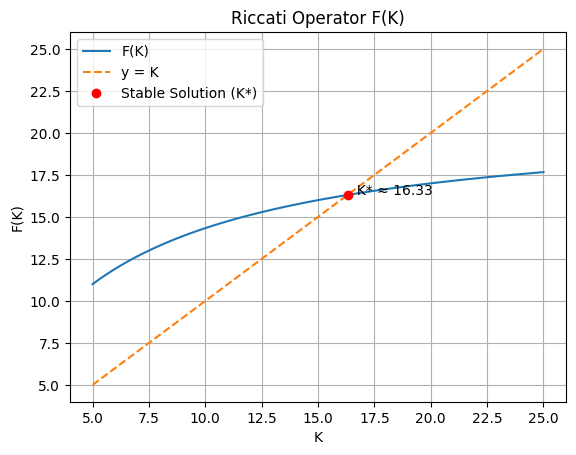

In [ ]:
# Define the Riccati operator
def F(K):
    return (a**2 * r * K) / (r + b**2 * K) + q

# Domain for plotting
K_domain = np.linspace(5, 25, 400)

# Calculate F(K) values
F_values = F(K_domain)

# Plot F(K)
plt.plot(K_domain, F_values, label="F(K)")
plt.plot(K_domain, K_domain, label="y = K", linestyle="--")  # Line y = K
plt.xlabel("K")
plt.ylabel("F(K)")
plt.title("Riccati Operator F(K)")
plt.legend()
plt.grid(True)

# Find the intersection (solution of Riccati equation)
K_star = K_domain[np.argmin(np.abs(F_values - K_domain))]
plt.plot(K_star, F(K_star), "ro", label="Stable Solution (K*)") # Mark stable solution
plt.text(K_star, F(K_star), f'  K* ≈ {K_star:.2f}')
plt.legend()

plt.show()

## Question 2: Control Constrained Riccati Equation

Plot and solve graphically the Riccati equation corresponding to the linear policy $\mu(x) = -\frac{3}{2}x$.

Constrained Policy Parameter (L_constrained): -1.53


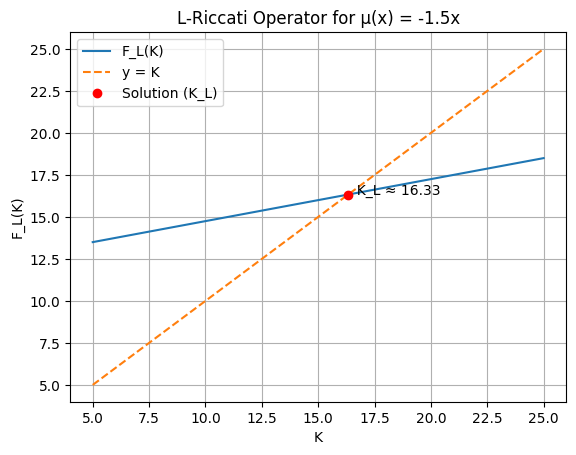

In [ ]:
L = -3/2 # Given policy parameter

# Define the L-Riccati operator
def F_L(K):
    return (a + b*L)**2 * K + q + r*L**2

# Domain for plotting
K_domain = np.linspace(5, 25, 400)

# Calculate F_L(K) values
F_L_values = F_L(K_domain)

# Plot F_L(K) and y = K
plt.plot(K_domain, F_L_values, label="F_L(K)")
plt.plot(K_domain, K_domain, label="y = K", linestyle="--")
plt.xlabel("K")
plt.ylabel("F_L(K)")
plt.title(f"L-Riccati Operator for μ(x) = {L}x")
plt.legend()
plt.grid(True)

# Find the intersection (solution of L-Riccati equation)
K_L = K_domain[np.argmin(np.abs(F_L_values - K_domain))]
plt.plot(K_L, F_L(K_L), "ro", label=f"Solution (K_L)")
plt.text(K_L, F_L(K_L), f'  K_L ≈ {K_L:.2f}')
plt.legend()

# Calculate the constrained policy parameter
L_constrained = - (a * b * K_L) / (r + b**2 * K_L)
print(f"Constrained Policy Parameter (L_constrained): {L_constrained:.2f}")

plt.show()

## Question 3: Value Iteration (VI)

Compute the numerical solution of Riccati equation using value iteration and plot the iterations $K_0,K_1,K_2, \ldots$ on the curve $F(K)$. Check the convergence for different starting points, i.e. $K_0 < K^*$ and $K^* > K_0$.

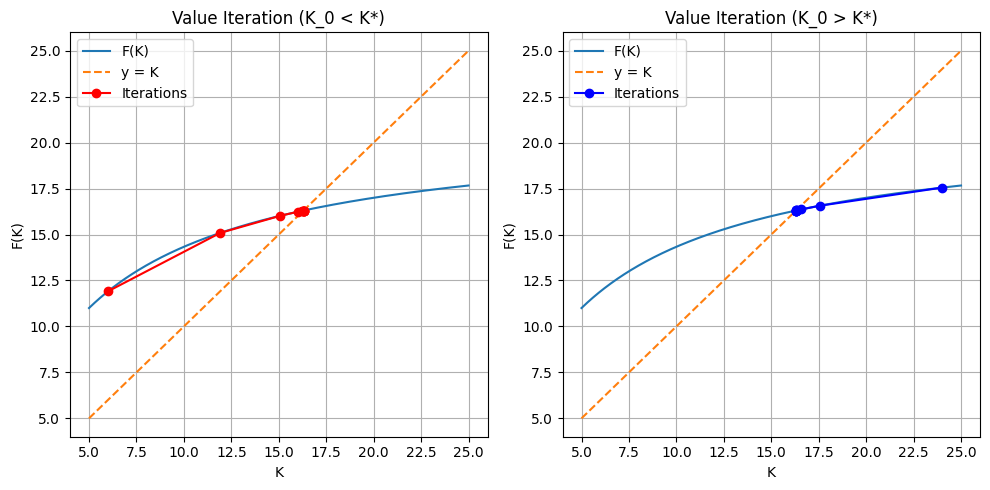

Convergence for K_0 = 6: K = 16.3066
Convergence for K_0 = 24: K = 16.3066


In [ ]:
# Define the Riccati operator
def F(K):
    return (a**2 * r * K) / (r + b**2 * K) + q

# Value Iteration Algorithm
def value_iteration(K_0, num_iterations):
    K_values = [K_0]
    for _ in range(num_iterations):
        K_next = F(K_values[-1])
        K_values.append(K_next)
    return K_values

# Domain for plotting F(K)
K_domain = np.linspace(5, 25, 400)
F_values = F(K_domain)

# --- Case 1: K_0 < K* ---
K_0_1 = 6  # Starting point less than K*
K_values_1 = value_iteration(K_0_1, 10)  # Calculate iterations

plt.figure(figsize=(10, 5))

# Plot F(K)
plt.subplot(1, 2, 1)
plt.plot(K_domain, F_values, label="F(K)")
plt.plot(K_domain, K_domain, label="y = K", linestyle="--")
plt.xlabel("K")
plt.ylabel("F(K)")
plt.title("Value Iteration (K_0 < K*)")
plt.grid(True)

# Plot VI iterations
plt.plot(K_values_1, F(np.array(K_values_1)), "ro-", label="Iterations")
plt.legend()

# --- Case 2: K_0 > K* ---
K_0_2 = 24  # Starting point greater than K*
K_values_2 = value_iteration(K_0_2, 10)  # Calculate iterations

# Plot F(K)
plt.subplot(1, 2, 2)
plt.plot(K_domain, F_values, label="F(K)")
plt.plot(K_domain, K_domain, label="y = K", linestyle="--")
plt.xlabel("K")
plt.ylabel("F(K)")
plt.title("Value Iteration (K_0 > K*)")
plt.grid(True)

# Plot VI iterations
plt.plot(K_values_2, F(np.array(K_values_2)), "bo-", label="Iterations")
plt.legend()

plt.tight_layout()
plt.show()

# Print convergence results
print(f"Convergence for K_0 = {K_0_1}: K = {K_values_1[-1]:.4f}")
print(f"Convergence for K_0 = {K_0_2}: K = {K_values_2[-1]:.4f}")

## Question 4: Value Approximation as Newton Step

Assume a terminal cost approximation $\tilde{K}$. Using the functions $F_L$, show graphically how the approximation in value space with $l$-step lookahead, with $l = \{1,2,3\}$, can be seen as successive application of Newton method.

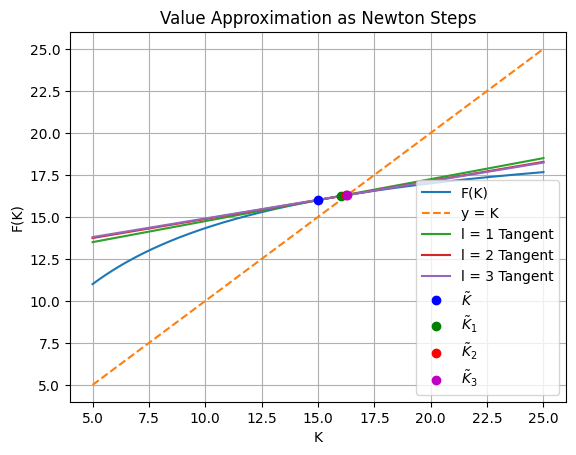

In [ ]:
# Define the Riccati operator and L-Riccati operator
def F(K):
    return (a**2 * r * K) / (r + b**2 * K) + q

def F_L(K, L):
    return (a + b * L)**2 * K + q + r * L**2

# Domain for plotting
K_domain = np.linspace(5, 25, 400)
F_values = F(K_domain)

# Terminal cost approximation
K_tilde = 15

# --- One-Step Lookahead (l = 1) ---
L_tilde = - (a * b * K_tilde) / (r + b**2 * K_tilde)  # Minimizing L
K_tilde_1 = F_L(K_tilde, L_tilde)

# --- Two-Step Lookahead (l = 2) ---
L_tilde_1 = - (a * b * K_tilde_1) / (r + b**2 * K_tilde_1)
K_tilde_2 = F_L(K_tilde_1, L_tilde_1)

# --- Three-Step Lookahead (l = 3) ---
L_tilde_2 = - (a * b * K_tilde_2) / (r + b**2 * K_tilde_2)
K_tilde_3 = F_L(K_tilde_2, L_tilde_2)

# Plotting
plt.plot(K_domain, F_values, label="F(K)")
plt.plot(K_domain, K_domain, label="y = K", linestyle="--")

# Plot the tangent lines for each lookahead step
plt.plot(K_domain, F_L(K_domain, L_tilde), label="l = 1 Tangent")
plt.plot(K_domain, F_L(K_domain, L_tilde_1), label="l = 2 Tangent")
plt.plot(K_domain, F_L(K_domain, L_tilde_2), label="l = 3 Tangent")

# Mark the points on the F(K) curve
plt.plot(K_tilde, F(K_tilde), 'bo', label=r'$\tilde{K}$')
plt.plot(K_tilde_1, F(K_tilde_1), "go", label=r'$\tilde{K}_1$')
plt.plot(K_tilde_2, F(K_tilde_2), "ro", label=r'$\tilde{K}_2$')
plt.plot(K_tilde_3, F(K_tilde_3), "mo", label=r'$\tilde{K}_3$')

plt.xlabel("K")
plt.ylabel("F(K)")
plt.title("Value Approximation as Newton Steps")
plt.legend()
plt.grid(True)
plt.show()

**Bonus:** How does the stability set, i.e., the set of $\tilde{K}$ for which the resulting policy is stable, change with multiple lookahead steps?

As you increase the number of lookahead steps $l$, the stability set **generally expands**. This means that with more lookahead, you can start with a wider range of initial $\tilde{K}$ values and still end up with a stable policy.

From the previous plot you can see that as the lookahead steps increase, the tangent lines get progressively closer to the stable solution $K^*$. This suggests that even if you started with a $\tilde{K}$ to the left of the unstable region (where the one-step tangent has a slope greater than 1), the two-step or three-step lookahead could lead you to a $K$ value in the stable region.

A clear plot suggesting the above can be seen below.

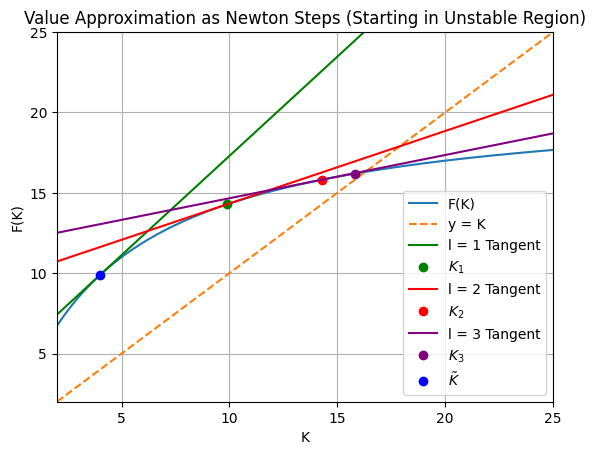

In [ ]:
# Define the Riccati operator and L-Riccati operator
def F(K):
    return (a**2 * r * K) / (r + b**2 * K) + q

def F_L(K, L):
    return (a + b * L)**2 * K + q + r * L**2

# Domain for plotting
K_domain = np.linspace(2, 25, 400)  # Adjusted to include more of the unstable region
F_values = F(K_domain)

# Terminal cost approximation (starting in the unstable region)
K_tilde = 4

# Calculate lookahead steps and tangent lines
K_values = [K_tilde]
L_values = []
for l in range(1, 4):  # Lookahead steps 1, 2, 3
    L_tilde = - (a * b * K_values[-1]) / (r + b**2 * K_values[-1])  # Minimizing L
    K_values.append(F_L(K_values[-1], L_tilde))
    L_values.append(L_tilde)

# Plotting
plt.plot(K_domain, F_values, label="F(K)")
plt.plot(K_domain, K_domain, label="y = K", linestyle="--")

colors = ["green", "red", "purple"]
for l in range(1, 4):
    plt.plot(K_domain, F_L(K_domain, L_values[l-1]), label=f"l = {l} Tangent", color=colors[l-1])
    label = rf"$K_{l}$"
    plt.plot(K_values[l], F(K_values[l]), "o", color=colors[l-1], label=label)

# Mark initial K_tilde
plt.plot(K_tilde, F(K_tilde), 'bo', label=r'$\tilde{K}$')

plt.xlabel("K")
plt.ylabel("F(K)")
plt.title("Value Approximation as Newton Steps (Starting in Unstable Region)")
plt.legend()
plt.grid(True)
plt.xlim(2, 25)  # Set x-axis limits
plt.ylim(2, 25)  # Set y-axis limits
plt.show()

# Robotic Exploration

Consider a world constituted by a rectangular grid, e.g.,

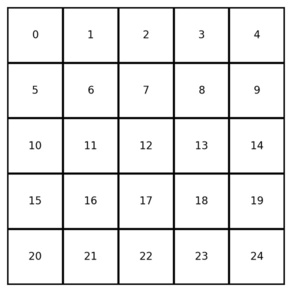

The cells of the grid correspond to the states of the environment. At each cell, four actions are possible: north (N), south (S), east (E), and west (W), which deterministically cause the agent to move one cell in the respective direction on the grid.
The objective is to find the closest source of water. At each step, depending on the type of terrain, the robot will consume a fixed amount of energy, i.e. 1 for flat terrain, 2 for forest terrain, 10 for fire terrain, etc.

 We start by explaining the implementation of the world class, representing our environment, by commenting the code.

In [ ]:
class World(object):
    def __init__(self, gridSize, terrain):

        #The world is represented as m x n matrix
        self.m = gridSize[0]
        self.n = gridSize[1]
        self.grid = np.zeros(gridSize)

        #The state space is represented by the position of the robot in our grid.
        #We can list all possible states by enumerating, as in the previous figure,
        #the locations in row-major order.
        self.state_space = list(range(self.m * self.n))

        #We fix a base cost to move between locations, which,
        #depending on the terrain type, will be modified.
        self.step_reward = -1

        #We store the dictionary
        #{"terrain-type": { "loc": [],          ## list of indexes of position of that terrain type
        #                   "reward": a }}      ## reward associated with that terrain
        self.terrain = terrain

        #Definition of the action space, which corresponds with the four possible directions.
        self.action_space = {'N': -self.m, 'S': self.m, 'W': -1, 'E': 1, 'R': 0}
        self.actions = ['N', 'S', 'W', 'E', 'R']

        #Set up the dictionary indexed by the tuple (state, action) containing the Q-values Q(s,a)
        self.P = self.int_P()

    def int_P(self):
        #For each (state, action) tuple, associate a (next_state, reward) tuple.
        P = {}
        for state in self.state_space:
            for action in self.actions:
                reward = self.step_reward
                n_state = state + self.action_space[action]

                if n_state in self.terrain.get('fire').get('loc'):
                    reward += self.terrain.get('fire').get('reward')

                elif n_state in self.terrain.get('rock').get('loc'):
                    reward += self.terrain.get('rock').get('reward')

                elif n_state in self.terrain.get('water').get('loc'):
                    reward += self.terrain.get('water').get('reward')

                elif self.check_move(n_state, state):
                    n_state = state

                P[(state ,action)] = (n_state, reward)
        return P

    def check_terminal(self, state):
        #Check if the location is a water location, i.e. it is a terminal state.
        return state in self.terrain.get('water').get('loc')

    def check_move(self, n_state, oldState):
        #Check if the movement is valid, i.e., still inside the world border.
        if n_state not in self.state_space:
            return True
        elif oldState % self.m == 0 and n_state % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m - 1 and n_state % self.m == 0:
            return True
        else:
            return False

## Question 1: Value Iteration
Your task is to implement the Value-Iteration algorithm to compute the optimal exploration policy. \\
As a reminder, the pseudo code of VI is given in the following:

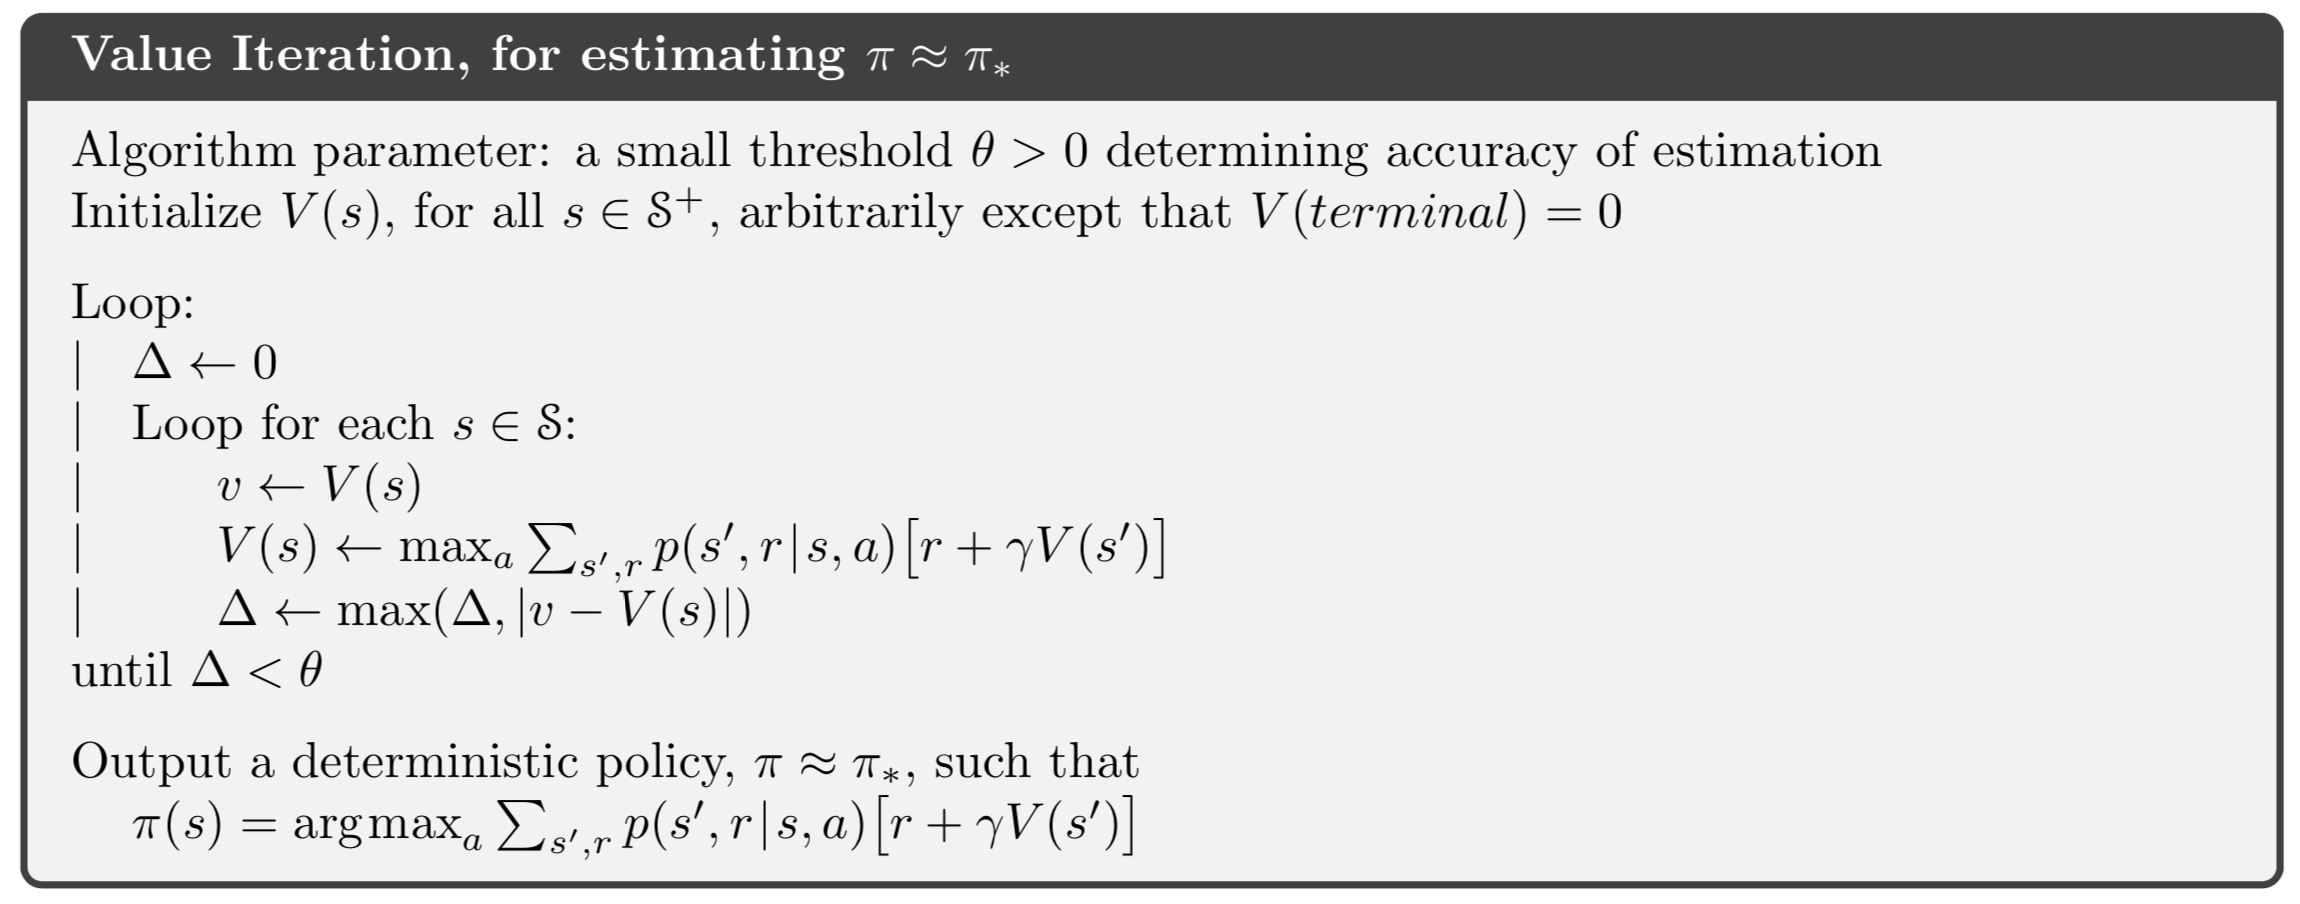

In [ ]:
def ValueIteration(grid, v, policy, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.

    Args:
        grid: An instance of the World() class representing the environment.
        v: Array storing the cost J for each state.
        policy: Array indexed by states storing the policy action.
        theta: Stopping threshold for VI.
        discount_factor: Gamma discount factor.

    Returns:
        A tuple (v, policy) of the updated cost function and policy.
    """

    # VALUE ITERATION LOOP
    while True:
        delta = 0
        for state in grid.state_space:
            if grid.check_terminal(state):
                continue
            old_v = v[state]
            Q_values = []
            for action in grid.actions:
                next_state, reward = grid.P[(state, action)]
                Q_values.append(reward + discount_factor * v[next_state])

            v[state] = max(Q_values)  # Update the cost function
            delta = max(delta, abs(old_v - v[state]))

        if delta < theta:  # Check for convergence
            break

    # OPTIMAL DETERMINISTIC POLICY COMPUTATION
    for state in grid.state_space:
        Q_values = []
        for action in grid.actions:
            next_state, reward = grid.P[(state, action)]
            Q_values.append(reward + discount_factor * v[next_state])

        best_action_index = np.argmax(Q_values)
        policy[state] = grid.actions[best_action_index]

    return v, policy

Now, test the implemented algorithm on the following example.

In [ ]:
# Instantiate the World
## It is possible to implement other terrains by modifing the World() class

grid_size = (5, 5)
items = { 'fire': {'reward': -10, 'loc': [12, 14, 19, 22, 23, 24]},
          'rock': {'reward': -1, 'loc': [13, 17]},
          'water': {'reward': 10, 'loc': [18, 0]}
        }

env = World(grid_size, items)


# Training using VI
v = np.zeros(np.prod(grid_size))              #All rewards are initially set to 0
policy = np.full(np.prod(grid_size), 'R')     #Initiallize with a "random" action

v, policy = ValueIteration(env, v, policy)

The following function allow to plot the results of the VI and the optimal policy.

In [ ]:
def print_v(v, grid):
    v = np.reshape(v, (grid.n, grid.m))

    cmap = mpl.colormaps['Greens']
    norm = plt.Normalize(v.min(), v.max())
    rgba = cmap(norm(v))

    for w in grid.terrain.get('water').get('loc'):
        idx = np.unravel_index(w, v.shape)
        rgba[idx] = 0.0, 0.5, 0.8, 1.0

    for f in grid.terrain.get('fire').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.1, 1.0

    for f in grid.terrain.get('rock').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.5, 1

    fig, ax = plt.subplots()
    im = ax.imshow(rgba, interpolation='nearest')

    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
              text = ax.text(j, i, v[i, j], ha="center", va="center", color="w")

    plt.axis('off')
    plt.show()


def print_policy(v, policy, grid):
    v = np.reshape(v, (grid.n, grid.m))
    policy = np.reshape(policy, (grid.n, grid.m))

    cmap = mpl.colormaps['Greens']
    norm = plt.Normalize(v.min(), v.max())
    rgba = cmap(norm(v))

    for w in grid.terrain.get('water').get('loc'):
        idx = np.unravel_index(w, v.shape)
        rgba[idx] = 0.0, 0.5, 0.8, 1.0

    for f in grid.terrain.get('fire').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.1, 1.0

    for f in grid.terrain.get('rock').get('loc'):
        idx = np.unravel_index(f, v.shape)
        rgba[idx] = 1.0, 0.5, 0.5, 1

    fig, ax = plt.subplots()
    im = ax.imshow(rgba, interpolation='nearest')

    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            text = ax.text(j, i, policy[i, j], ha="center", va="center", color="w")

    plt.axis('off')
    plt.show()

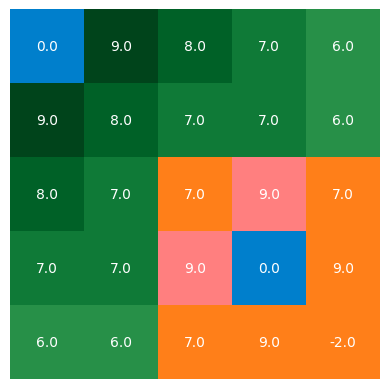

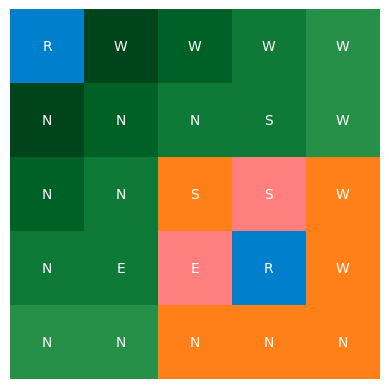

In [ ]:
print_v(v, env)
print_policy(v, policy, env)

## Question 2: Curse of Dimensionality

Consider the following example where a map of size NxN is randomly generated. How does the complexity of the VI algorithm depends on N? Plot the training time as function of N and explain the results.

In [ ]:
# Instantiate the World
## It is possible to implement other terrains by modifing the World() class
import random

N = 10
grid_size = (N, N)
n_squares = grid_size[0] * grid_size[1]
NW = int(np.ceil(0.02 * n_squares))
NF = int(np.ceil(0.25 * n_squares))
NR = int(np.ceil(0.25 * n_squares))
locs = random.sample(range(1, n_squares), NW + NF + NR)
items = { 'water': {'reward': 10, 'loc': locs[0:NW]},
          'fire': {'reward': -10, 'loc': locs[NW: NW + NF]},
          'rock': {'reward': -1, 'loc': locs[NW+NF:]}
        }

env = World(grid_size, items)


# Training using VI
v = np.zeros(np.prod(grid_size))              #All rewards are initially set to 0
policy = np.full(np.prod(grid_size), 'R')     #Initiallize with a "random" action

v, policy = ValueIteration(env, v, policy)

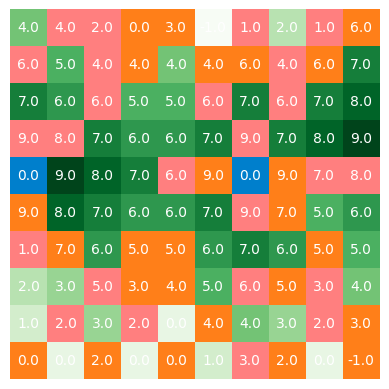

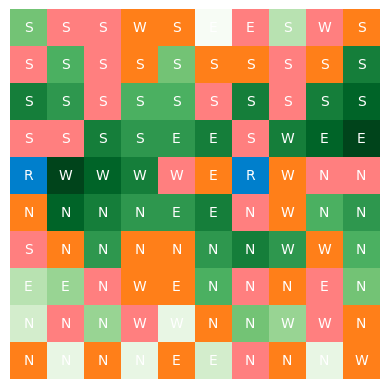

In [ ]:
print_v(v, env)
print_policy(v, policy, env)

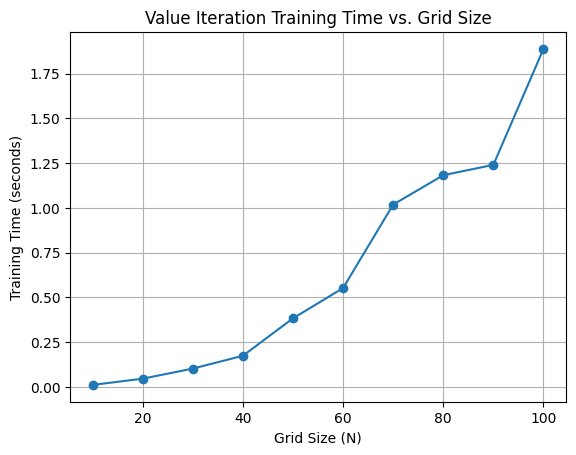

In [ ]:
import time

# Experiment with different N values
N_values = range(10, 101, 10)  # Example: N from 10 to 100 in steps of 10
#N_values = range(5, 51, 5)  # Example: N from 5 to 50 in steps of 5
training_times = []

for N in N_values:
    grid_size = (N, N)
    n_squares = grid_size[0] * grid_size[1]
    NW = int(np.ceil(0.02 * n_squares))
    NF = int(np.ceil(0.25 * n_squares))
    NR = int(np.ceil(0.25 * n_squares))
    locs = random.sample(range(1, n_squares), NW + NF + NR)
    items = {
        'water': {'reward': 10, 'loc': locs[0:NW]},
        'fire': {'reward': -10, 'loc': locs[NW: NW + NF]},
        'rock': {'reward': -1, 'loc': locs[NW+NF:]}
    }

    env = World(grid_size, items)

    # Training using VI and measure time
    v = np.zeros(np.prod(grid_size))
    policy = np.full(np.prod(grid_size), 'R')

    start_time = time.time()
    v, policy = ValueIteration(env, v, policy)
    end_time = time.time()

    training_times.append(end_time - start_time)

# Plot training time vs. N
plt.plot(N_values, training_times, marker='o')
plt.xlabel("Grid Size (N)")
plt.ylabel("Training Time (seconds)")
plt.title("Value Iteration Training Time vs. Grid Size")
plt.grid(True)
plt.show()

**Explanation of the Results:**

- The training time generally increases as $N$ grows. This is expected, as a larger grid means a larger state space, and VI needs to update the value of each state in every iteration.
- The increase in training time is *not linear*. For our chosen $N$ values it appears to be almost exponential. This is a key indicator of the **curse of dimensionality**.
- There are some fluctuations in the training time for different values of $N$. This is due to the randomness in generating the map. The specific arrangement of obstacles (fire, rock) and the water source can affect the number of iterations required for VI to converge.

**Explanation of the Curse of Dimensionality:**

As the grid size ($N$) increases:

1. **State Space Explosion:** The number of states in the grid world grows quadratically ($N^2$).
2. **Computational Burden per Iteration:**  VI needs to update the value of each state in every iteration, so the computation required per iteration increases significantly.
3. **Potential for More Iterations:**  Larger state spaces often require more iterations for VI to converge to the optimal value function.